# Postprocess openfast results for sectional loads

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil, io
for x in amrwindfedirs: sys.path.insert(1, x)

import postproamrwindsample_xarray as ppsample
import postproengine as ppeng
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

# Loaded ruamel.yaml


In [3]:
def stringReplaceDict(s, dreplace):
    outstr = str(s)
    for k, g in dreplace.items():
        outstr=outstr.replace(k, g)
    return outstr

In [4]:
def makeSecBladeDF(csvfile, rpts, bladekeysdict):
    """
    Make a dictionary with blade sectional loading quantities
    """
    df=pd.read_csv(csvfile, comment='#',)
    bladedf = {}
    bladedf['rpts'] = rpts
    for k, bladekeys in bladekeysdict.items():
        alphadat = [float(df[k][0]) for k in bladekeys]
        bladedf[k] = alphadat
    return bladedf

In [5]:
# Create a list of blade variables
Npts = 19
prefix='AB1N'

# Create a dictionary with keys that need to be pulled out
suffixkeys = ['Alpha', 'Phi', 'Cl','Cd', 'Fx','Fy']
blistdict  = {}
for suffix in suffixkeys:
    blistdict[suffix] = [prefix+('%03i'%i)+suffix for i in range(1, Npts+1)]

blist = []
for k, g in blistdict.items():
    blist += g
bliststr  = '[Time, '+', '.join(blist)+']'

In [6]:
# Get the blade stations
rundir = '/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_RIGID_OFv402/'
bladefile = rundir+'/T0_NREL5MW_v402_RIGID/openfast/5MW_Baseline/NRELOffshrBsline5MW_AeroDyn_blade.dat'
bladedat  = np.genfromtxt(bladefile, skip_header=6, skip_footer=2)

In [7]:
replacedict={'RUNDIR':rundir,
             'RESULTSDIR':'../results/OpenFAST_v402_out',
             'BLADEVARS':bliststr,
            }

In [8]:
yamlstring="""
globalattributes:
  verbose: False
  udfmodules: []
  executeorder:
  - openfast
  
trange: &trange [300, 900]   # Note: add 15,000 sec to get AMR-Wind time

openfast:
# For FSI case
- name: NREL5MW_SECLOADS
  filename: RUNDIR/T0_NREL5MW_v402_RIGID/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.out
  vars: BLADEVARS
  output_dir: RESULTSDIR
  csv:  # Store information to CSV files
    individual_files: False
  operate:
    operations: 
    - mean
    trange: *trange
"""
f = io.StringIO(stringReplaceDict(yamlstring, replacedict))
yamldict = Loader(f, **loaderkwargs)

In [9]:
# Run the driver
ppeng.driver(yamldict, verbose=True)

Initialized openfast
Running openfast
NREL5MW_SECLOADS /gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_RIGID_OFv402//T0_NREL5MW_v402_RIGID/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.out
Initialized csv inside NREL5MW_SECLOADS
Executing csv
Initialized operate inside NREL5MW_SECLOADS
Executing operate


In [10]:
d = makeSecBladeDF(replacedict['RESULTSDIR']+'/NREL5MW_SECLOADS_mean.csv', bladedat[:,0], blistdict)
pddf = pd.DataFrame(d).to_csv(replacedict['RESULTSDIR']+'/NREL5MW_SECLOADS_mean_rpts.csv',  index=False,float_format='%.15f')

## Plot the blade loading

In [11]:
yamlstring="""
globalattributes:
  verbose: False
  udfmodules: []
  executeorder:
  #- openfast
  - plotcsv
  
trange: &trange [300, 900]   # Note: add 15,000 sec to get AMR-Wind time

plotcsv:
  - name: Blade AOA
    xlabel: 'Blade span r [m]'
    ylabel: 'AOA [deg]'
    title: 'Blade AOA'
    figsize: [10,4]
    legendopts: {'loc':'upper right'}
    savefile: ../results/images/OpenFAST_T0_AOA.png
    csvfiles:
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Alpha', 'lineopts':{'color':'b', 'lw':1, 'linestyle':'-', 'label':'Alpha'}}    
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Phi', 'lineopts':{'color':'r', 'lw':1, 'linestyle':'-', 'label':'Phi'}}  
    
  - name: Blade AOA
    xlabel: 'Blade span r [m]'
    ylabel: 'Cl/Cd [-]'
    title: 'Blade Cl/Cd'
    figsize: [10,4]
    legendopts: {'loc':'upper right'}
    savefile: ../results/images/OpenFAST_T0_ClCd.png
    csvfiles:
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Cl', 'lineopts':{'color':'b', 'lw':1, 'linestyle':'-', 'label':'Cl'}}    
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Cd', 'lineopts':{'color':'r', 'lw':1, 'linestyle':'-', 'label':'Cd'}}   
    
  - name: Blade loading
    xlabel: 'Blade span r [m]'
    ylabel: 'Blade forces [N]'
    title: 'Blade loading'
    figsize: [10,4]
    legendopts: {'loc':'upper right'}
    savefile: ../results/images/OpenFAST_T0_FxFy.png
    csvfiles:
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Fx', 'lineopts':{'color':'b', 'lw':1, 'linestyle':'-', 'label':'Fx'}}    
    - {'file':'RESULTSDIR/NREL5MW_SECLOADS_mean_rpts.csv', 'xcol':'rpts', 'ycol':'Fy', 'lineopts':{'color':'r', 'lw':1, 'linestyle':'-', 'label':'Fy'}}   

"""
f = io.StringIO(stringReplaceDict(yamlstring, replacedict))
yamldict = Loader(f, **loaderkwargs)

Initialized plotcsv
Running plotcsv
Saving ../results/images/OpenFAST_T0_AOA.png
Saving ../results/images/OpenFAST_T0_ClCd.png
Saving ../results/images/OpenFAST_T0_FxFy.png


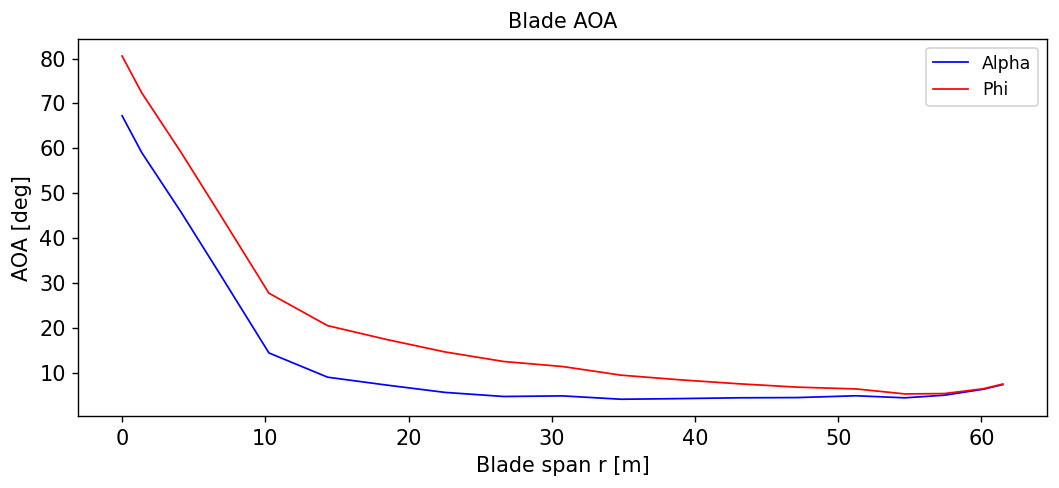

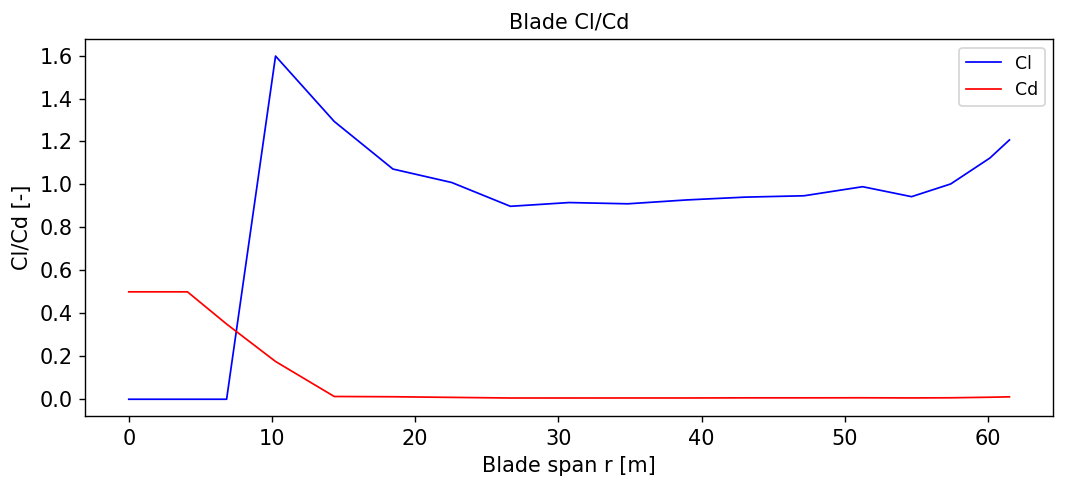

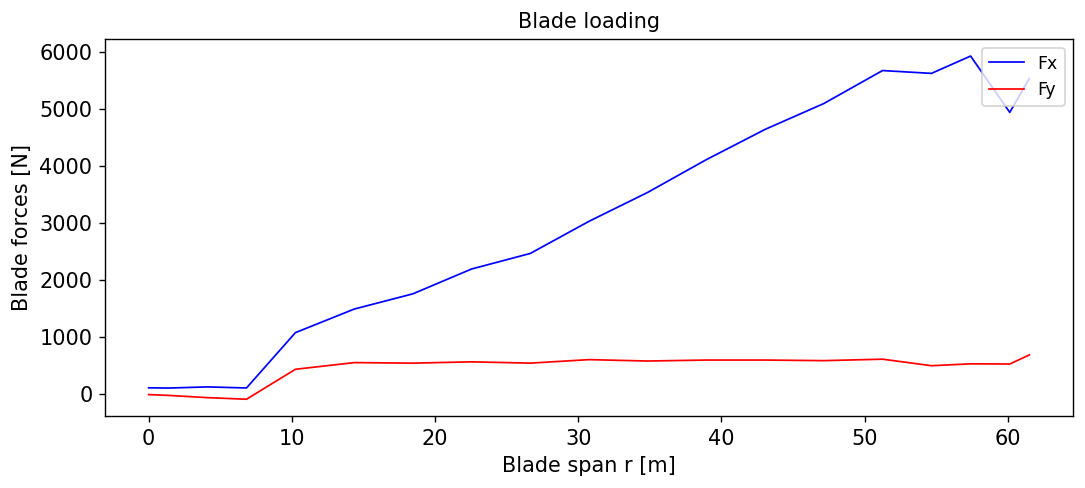

In [12]:
# Run the driver
ppeng.driver(yamldict, verbose=True)

In [13]:
# Write out the notebook to a python script
!jupyter nbconvert --to script OpenFAST_SectionalLoading.ipynb
with open('OpenFAST_SectionalLoading.py', 'r') as f:
    lines = f.readlines()
with open('OpenFAST_SectionalLoading.py', 'w') as f:
    for line in lines:
        if "'matplotlib', 'inline'" in line: line = 'plt.show(block=False)'
        if 'nbconvert --to script' in line:
            break
        else:
            f.write(line)

[NbConvertApp] Converting notebook OpenFAST_SectionalLoading.ipynb to script
[NbConvertApp] Writing 5880 bytes to OpenFAST_SectionalLoading.py
